In [77]:
import numpy as np
from numpy import array
import numpy.polynomial.polynomial as poly
import pandas as pd
import datetime as dt
import seaborn
import matplotlib.pylab as plt
import os
import random
import shutil
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [78]:
df = pd.read_csv('indexData.csv')

In [79]:
df.head()

,Index,Date,Open,High,Low,Close,Adj Close,Volume
0,NYA,1965-12-31,528.690002,528.690002,528.690002,528.690002,528.690002,0.0
1,NYA,1966-01-03,527.210022,527.210022,527.210022,527.210022,527.210022,0.0
2,NYA,1966-01-04,527.840027,527.840027,527.840027,527.840027,527.840027,0.0
3,NYA,1966-01-05,531.119995,531.119995,531.119995,531.119995,531.119995,0.0
4,NYA,1966-01-06,532.070007,532.070007,532.070007,532.070007,532.070007,0.0


In [80]:
df["Date"] = pd.to_datetime(df["Date"])
df_NYA = df[df["Index"].isin(['NYA'])].sort_values('Date')
df_NYA

,Index,Date,Open,High,Low,Close,Adj Close,Volume
0,NYA,1965-12-31,528.690002,528.690002,528.690002,528.690002,528.690002,0.000000e+00
1,NYA,1966-01-03,527.210022,527.210022,527.210022,527.210022,527.210022,0.000000e+00
2,NYA,1966-01-04,527.840027,527.840027,527.840027,527.840027,527.840027,0.000000e+00
3,NYA,1966-01-05,531.119995,531.119995,531.119995,531.119995,531.119995,0.000000e+00
4,NYA,1966-01-06,532.070007,532.070007,532.070007,532.070007,532.070007,0.000000e+00
...,...,...,...,...,...,...,...,...
13943,NYA,2021-05-24,16375.000000,16508.519530,16375.000000,16464.689450,16464.689450,2.947400e+09
13944,NYA,2021-05-25,16464.689450,16525.810550,16375.150390,16390.189450,16390.189450,3.420870e+09
13945,NYA,2021-05-26,16390.189450,16466.339840,16388.320310,16451.960940,16451.960940,3.674490e+09
13946,NYA,2021-05-27,16451.960940,16546.359380,16451.960940,16531.949220,16531.949220,5.201110e+09


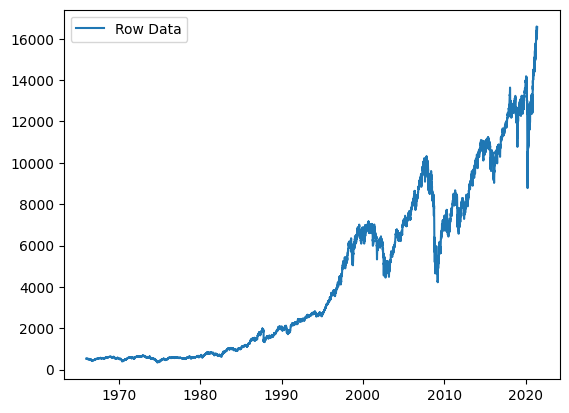

In [81]:
plt.plot(df_NYA["Date"],df_NYA["Close"],label='Row Data')
plt.legend()


In [82]:
df_NYA_data_close = df_NYA[["Date","Close"]]
df_NYA_data_close


,Date,Close
0,1965-12-31,528.690002
1,1966-01-03,527.210022
2,1966-01-04,527.840027
3,1966-01-05,531.119995
4,1966-01-06,532.070007
...,...,...
13943,2021-05-24,16464.689450
13944,2021-05-25,16390.189450
13945,2021-05-26,16451.960940
13946,2021-05-27,16531.949220


In [83]:
df_NYA_data_close.isnull().sum()

Date     0
Close    1
dtype: int64

In [84]:
df_NYA_data_close.index


Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
       ...
       13938, 13939, 13940, 13941, 13942, 13943, 13944, 13945, 13946, 13947],
      dtype='int64', length=13948)

In [85]:
np.where(df_NYA_data_close['Close'].isnull())[0]

array([289])

In [86]:
df_NYA_data_close.iloc[[289]]

,Date,Close
289,1967-02-23,NaN


In [87]:
df_NYA_data_close_withoutnan = df_NYA_data_close.dropna()
df_NYA_data_close_withoutnan.isnull().sum()

Date     0
Close    0
dtype: int64

In [88]:
np.where(df_NYA_data_close_withoutnan['Close'].isnull())[0]

array([], dtype=int64)

In [89]:
data_train = df_NYA_data_close_withoutnan[df_NYA_data_close_withoutnan.Date < "2010-01-01"]
data_test = df_NYA_data_close_withoutnan[df_NYA_data_close_withoutnan.Date >= "2010-01-01"]
data_train

,Date,Close
0,1965-12-31,528.690002
1,1966-01-03,527.210022
2,1966-01-04,527.840027
3,1966-01-05,531.119995
4,1966-01-06,532.070007
...,...,...
11072,2009-12-24,7255.000000
11073,2009-12-28,7261.240234
11074,2009-12-29,7252.189941
11075,2009-12-30,7241.240234


In [90]:
data_train.Date = data_train.Date.map(dt.datetime.toordinal)
X_train = np.array(data_train.Date)[:, np.newaxis]


/var/folders/h8/51x7qy5s3vvb8sqldgx055400000gn/T/ipykernel_44609/3535225291.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train.Date = data_train.Date.map(dt.datetime.toordinal)


In [92]:
X_train

array([[717701],
       [717704],
       [717705],
       ...,
       [733770],
       [733771],
       [733772]])

In [93]:
y_train = data_train.Close

In [94]:
y_train.isnull().sum()

0

In [96]:
tree = DecisionTreeRegressor(criterion='squared_error', max_depth=50).fit(X_train, y_train)


In [97]:
linear_reg = LinearRegression().fit(X_train, y_train)

In [98]:
model_rf = RandomForestRegressor(n_estimators=100).fit(X_train, y_train)

In [100]:
X_all = np.array(df_NYA_data_close_withoutnan.Date.map(dt.datetime.toordinal))[:, np.newaxis]


In [101]:
X_all

array([[717701],
       [717704],
       [717705],
       ...,
       [737936],
       [737937],
       [737938]])

In [102]:
np.where(df_NYA_data_close_withoutnan['Date'] == '1966-01-05')[0]

array([3])

In [103]:
X_all[3]

array([717706])

In [104]:
pred_tree = tree.predict(X_all)
pred_model_rf = model_rf.predict(X_all)
pred_lr = linear_reg.predict(X_all)
X = np.array(data_train.Date)
y = np.array(data_train.Close)
model_coef_polyfit = poly.polyfit(X, y, 3)
X_new = np.array(df_NYA_data_close_withoutnan.Date.map(dt.datetime.toordinal))
ffit = poly.polyval(X_new, model_coef_polyfit)
X_new = pd.DataFrame(X_new,columns=['Date'])
X_new = X_new.Date.map(dt.datetime.fromordinal)

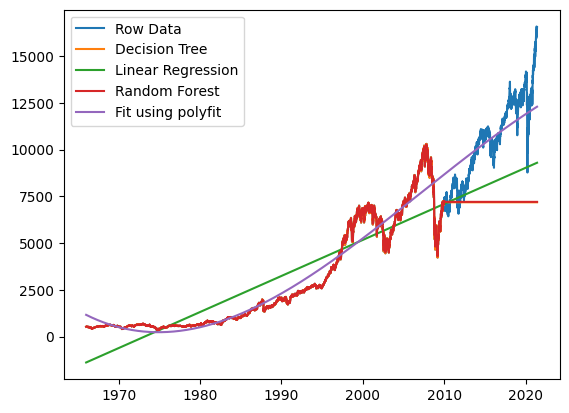

In [105]:
plt.plot(df_NYA_data_close_withoutnan.Date,df_NYA_data_close_withoutnan.Close,label='Row Data')
plt.plot(df_NYA_data_close_withoutnan.Date,pred_tree,label='Decision Tree')
plt.plot(df_NYA_data_close_withoutnan.Date,pred_lr,label='Linear Regression')
plt.plot(df_NYA_data_close_withoutnan.Date,pred_model_rf,label='Random Forest')
plt.plot(X_new,ffit,label='Fit using polyfit')
plt.legend()

In [106]:
tree.score(X_all,df_NYA_data_close_withoutnan.Close)

0.7973522670100477

In [107]:
linear_reg.score(X_all,df_NYA_data_close_withoutnan.Close)

0.8281145573435139

In [108]:
model_rf.score(X_all,df_NYA_data_close_withoutnan.Close)

0.7992230137217917

In [109]:
df_N100 = df[df["Index"].isin(['N100'])].sort_values('Date')
new_index = np.arange(0,len(df_N100.Close),1)
len(df_N100.Close)

5507

In [110]:
df_N100_data_close = df_N100[["Date","Close"]]
df_N100_data_close

,Date,Close
106950,1999-12-31,1000.000000
106951,2000-01-03,996.770020
106952,2000-01-04,955.969971
106953,2000-01-05,930.260010
106954,2000-01-06,922.460022
...,...,...
112452,2021-05-27,1247.069946
112453,2021-05-28,1256.599976
112454,2021-05-31,1248.930054
112455,2021-06-01,1258.579956


In [111]:
df_N100_data_close.index

Index([106950, 106951, 106952, 106953, 106954, 106955, 106956, 106957, 106958,
       106959,
       ...
       112447, 112448, 112449, 112450, 112451, 112452, 112453, 112454, 112455,
       112456],
      dtype='int64', length=5507)

In [112]:
df_N100_data_close.isnull().sum()

Date      0
Close    33
dtype: int64

In [113]:
df_N100_data_close_withoutnan = df_N100_data_close.dropna()

In [114]:
len(df_N100_data_close_withoutnan.Close)

5474

In [115]:
df_N100_data_close_withoutnan.isnull().sum()

Date     0
Close    0
dtype: int64

In [116]:
data_train_N100 = df_N100_data_close_withoutnan[df_N100_data_close_withoutnan.Date < "2015-01-01"]
data_test_N100 = df_N100_data_close_withoutnan[df_N100_data_close_withoutnan.Date >= "2015-01-01"]

In [117]:
df_N100_data_close_withoutnan.index

Index([106950, 106951, 106952, 106953, 106954, 106955, 106956, 106957, 106958,
       106959,
       ...
       112447, 112448, 112449, 112450, 112451, 112452, 112453, 112454, 112455,
       112456],
      dtype='int64', length=5474)

In [118]:
data_train_N100.Date = data_train_N100.Date.map(dt.datetime.toordinal)

/var/folders/h8/51x7qy5s3vvb8sqldgx055400000gn/T/ipykernel_44609/3222743530.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train_N100.Date = data_train_N100.Date.map(dt.datetime.toordinal)


In [119]:
data_train_N100.Close

106950    1000.000000
106951     996.770020
106952     955.969971
106953     930.260010
106954     922.460022
             ...     
110811     846.840027
110812     843.859985
110813     846.969971
110814     834.340027
110815     839.520020
Name: Close, Length: 3834, dtype: float64

In [121]:
X_train_N100 = np.array(data_train_N100.Date)[:, np.newaxis]
y_train_N100 = data_train_N100.Close

In [123]:
tree_N100 = DecisionTreeRegressor(criterion='squared_error', max_depth=50).fit(X_train_N100, y_train_N100)
linear_reg_N100 = LinearRegression().fit(X_train_N100, y_train_N100)
model_rf_N100 = RandomForestRegressor(n_estimators=10).fit(X_train_N100, y_train_N100)

In [125]:
X_all_N100 = np.array(df_N100_data_close_withoutnan.Date.map(dt.datetime.toordinal))[:, np.newaxis]


In [126]:
pred_tree_N100 = tree_N100.predict(X_all_N100)
pred_lr_N100 = linear_reg_N100.predict(X_all_N100)
pred_model_rf_N100 = model_rf_N100.predict(X_all_N100)

In [127]:
X_N100 = np.array(data_train_N100.Date)
y_N100 = np.array(data_train_N100.Close)
model_coef_polyfit = poly.polyfit(X_N100, y_N100, 2)
X_new_N100 = np.array(df_N100_data_close_withoutnan.Date.map(dt.datetime.toordinal))
ffit_N100 = poly.polyval(X_new_N100, model_coef_polyfit)
X_new_N100 = pd.DataFrame(X_new_N100,columns=['Date'])
X_new_N100 = X_new_N100.Date.map(dt.datetime.fromordinal)

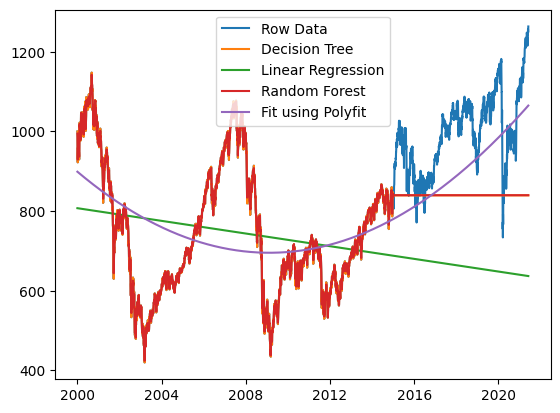

In [132]:
plt.plot(df_N100_data_close_withoutnan.Date,df_N100_data_close_withoutnan.Close,label='Row Data')
plt.plot(df_N100_data_close_withoutnan.Date,pred_tree_N100,label='Decision Tree')
plt.plot(df_N100_data_close_withoutnan.Date,pred_lr_N100,label='Linear Regression')
plt.plot(df_N100_data_close_withoutnan.Date,pred_model_rf_N100,label='Random Forest')
plt.plot(X_new_N100,ffit_N100,label='Fit using Polyfit')
plt.legend()